# Punto 3

El presente proyecto requiere de instalar las siguiente dependencia mendiante Maven, esto puede hacerse sin tener un proyecto de Maven mediante IntelliJ yendo directamente al apartado de librerías del proyecto [Control + Alt + Shift + S]

### Añadir la siguientes librerías:
```xml
org.jetbrains.kotlinx.dataframe
kennycason.kumo.core
jetbrains.kotlinx.kandy.lets.plot
```

In [1]:
import javax.xml.crypto.Data
import java.util.*
import kotlin.collections.*
import org.jetbrains.kotlinx.dataframe.*
import org.jetbrains.kotlinx.dataframe.api.*
import org.jetbrains.kotlinx.dataframe.io.*
import com.kennycason.kumo.*
import com.kennycason.kumo.palette.*
import com.kennycason.kumo.font.*
import com.kennycason.kumo.nlp.FrequencyAnalyzer
import org.jetbrains.kotlinx.kandy.letsplot.*
import java.util.Locale
import kotlin.random.Random // Para Random.nextInt()

// Dataframe
import org.jetbrains.kotlinx.dataframe.DataFrame
import org.jetbrains.kotlinx.dataframe.api.* // API principal de DataFrame (incluye get, filter, map, etc.)
import org.jetbrains.kotlinx.dataframe.io.* // Para readCSV, etc.
import org.jetbrains.kotlinx.dataframe.columns.* // Para DataColumn, ValueColumn si necesitas tipos explícitos

// Para renderizar HTML
import org.jetbrains.kotlinx.jupyter.api.HTML

// Para Kumo (nubes de palabras)
import com.kennycason.kumo.WordCloud
import com.kennycason.kumo.WordFrequency
import com.kennycason.kumo.CollisionMode
import com.kennycason.kumo.bg.CircleBackground
import com.kennycason.kumo.font.scale.SqrtFontScalar
import com.kennycason.kumo.palette.ColorPalette
import java.awt.Color
import java.awt.Dimension
import java.io.ByteArrayOutputStream
import java.util.Base64

In [2]:
var df_terms = DataFrame.readCSV("./terms.csv") // Cambia la ruta al archivo CSV
val df_resources = DataFrame.readCSV("../../resources/collection.csv") // Cambia la ruta al archivo CSV

# Logica para algoritmo Z

In [3]:
/**
 * Computes the Z-array for a given string s.
 * Z[i] = length of the longest substring starting at i
 * which is also a prefix of s.
 */
fun calculateZ(s: String): IntArray {
    val n = s.length
    val z = IntArray(n)
    var l = 0
    var r = 0

    for (i in 1 until n) {
        if (i > r) {
            // Case 1: i is outside the current Z-box
            l = i
            r = i
            while (r < n && s[r] == s[r - l]) {
                r++
            }
            z[i] = r - l
            r--
        } else {
            // Case 2: i is inside the current Z-box
            val k = i - l
            if (z[k] < r - i + 1) {
                // Case 2a: z[k] does not stretch outside the box
                z[i] = z[k]
            } else {
                // Case 2b: z[k] might stretch outside, so we compare manually
                l = i
                while (r < n && s[r] == s[r - l]) {
                    r++
                }
                z[i] = r - l
                r--
            }
        }
    }
    return z
}

/**
 * Finds all occurrences of `pattern` in `text` using the Z-algorithm.
 * Returns a list of starting indices in `text`.
 */
fun zAlgorithm(pattern: String, text: String): kotlin.collections.List<Int> {
    // Combine pattern, a delimiter not in pattern/text, and text
    val combined = pattern + "$" + text
    val z = calculateZ(combined)
    val m = pattern.length
    val result = mutableListOf<Int>()

    for (i in z.indices) {
        if (z[i] == m) {
            // i - m - 1 compensates for pattern + delimiter
            result.add(i - m - 1)
        }
    }
    return result
}

# Lógica

algunas funciones auxiliares que vamos a usar más adelante

In [4]:
/**
 * If any term in list of terms is a compound one, i.e, has more than one word, then Z algorithm with original abstract is used
 * If not, then, another algorithm is used -> The abstract is sorted and then the single word term is search
 * effienctly using binary search.
 * @param abstract shouldnt be sorted in this function.
 */
fun countTerms(terms: kotlin.collections.List<String>, abstract: String): Int {
    var count = 0
    for (term in terms) {
        if (term.split(" ").size >= 2) count += searchCompoundTerm(term, abstract)
        else count += countWordOccurrences(term, sortAndCleanAbstract(abstract))

    }
    return count
}

fun searchCompoundTerm(term: String, abstract: String) = zAlgorithm(
    term.lowercase(Locale.getDefault()),
    abstract.lowercase(Locale.getDefault())
).size



fun sortAndCleanAbstract(abstract: String): kotlin.collections.List<String> = abstract
    .lowercase(Locale.getDefault())
    .split("\\s+".toRegex())
    .asSequence()
    .map { it.trim().replace(Regex("""^\p{Punct}+|\p{Punct}+$"""), "") }
    .filter { it.isNotEmpty() }
    .sorted()
    .toList()

fun countWordOccurrences(word: String, sortedList: kotlin.collections.List<String>): Int {
    // Find any occurrence with binary search
    val index = Collections.binarySearch(sortedList, word)

    // Word not found
    if (index < 0) {
        return 0
    }

    // Count all occurrences (left and right of found index)
    var count = 1

    // Check left side
    var left = index - 1
    while (left >= 0 && sortedList[left] == word) {
        count++
        left--
    }

    // Check right side
    var right = index + 1
    while (right < sortedList.size && sortedList[right] == word) {
        count++
        right++
    }

    return count
}

fun countSetOfTerms(setOfTerms: kotlin.collections.List<String>, sortedList: kotlin.collections.List<String>): Int {
    var count = 0
    for (term in setOfTerms) {
        count += countWordOccurrences(term, sortedList)
    }
    return count
}

// Función para filtrar variables y sinonimos por categoría
fun filterByCategory(df: DataFrame<*>, category: String): kotlin.collections.List<kotlin.collections.List<String>> {
    var res = mutableListOf<kotlin.collections.List<String>>();
    df.filter { it.get("Categoria") == category }.rows().forEach { row ->
        val variable = row["Variable"] as String
        val synonymsStr = row["Sinonimos"] as String?

        // Create a mutable list starting with the variable
        val termList = mutableListOf(variable)

        // Add synonyms if they exist
        if (!synonymsStr.isNullOrEmpty()) {
            // Split synonyms by "|" and add them to the list
            termList.addAll(synonymsStr.split("|").map { it.trim().lowercase(Locale.getDefault()) })

        }

        // Add the complete list to our collection
        res.add(termList.toList())
    }
    return res.toList()
}


/**
 * Calculates the frequency of terms across a list of abstracts and returns sorted results
 *
 * @param termsList List of term lists (each inner list contains a term and its synonyms)
 * @param abstracts List of abstracts to search within
 * @return List of pairs containing term strings and their frequencies, sorted by frequency (descending)
 */
fun calculateTermFrequencies(
    termsList: kotlin.collections.List<kotlin.collections.List<String>>,
    abstracts: kotlin.collections.List<String>
): kotlin.collections.List<Pair<String, Int>> {
    val pairTermsFreq = mutableListOf<Pair<String, Int>>()

    termsList.forEach { terms ->
        // Calculate total count across all abstracts for this term
        val totalCount = abstracts.sumOf { abstract ->
            countTerms(terms, abstract)
        }
        // Add single entry with combined count
        pairTermsFreq.add(Pair(terms.joinToString(", "), totalCount))
    }

    // Sort by frequency (descending)
    return pairTermsFreq.sortedByDescending { it.second }
}

# Esquema de la base de datos

In [25]:
// Imprimir el esquema de la base de datos
df_terms.schema()

Categoria: String
Variable: String
Sinonimos: String?

In [26]:
import java.util.*

// Convert both "Variable" and "Sinonimos" columns to lowercase
df_terms = df_terms
.update { Variable }
.with { it.lowercase(Locale.getDefault()) }

.update { Sinonimos }
.with { it?.lowercase(Locale.getDefault()) }


df_terms

Categoria,Variable,Sinonimos
Habilidades,abstraction,null
Habilidades,algorithm,null
Habilidades,algorithmic thinking,null
Habilidades,coding,null
Habilidades,collaboration,null
Habilidades,cooperation,null
Habilidades,creativity,null
Habilidades,critical thinking,null
Habilidades,debug,null
Habilidades,decomposition,null


In [7]:
//Imprimimos las categorías
df_terms.distinct { Categoria }

Categoria
Habilidades
Conceptos Computacionales
Actitudes
Propiedades psicométricas
Herramienta de evaluación
Diseño de investigación
Nivel de escolaridad
Medio
Estrategia
Herramienta


## Lista de listas de terminos por categorias

In [8]:
val terms_habilidades = filterByCategory(df_terms, "Habilidades")
val terms_conceptos_comp = filterByCategory(df_terms, "Conceptos Computacionales")
val terms_actitudes= filterByCategory(df_terms, "Actitudes")
val terms_prop_psico = filterByCategory(df_terms, "Propiedades psicométricas")
val terms_herramienta_eval = filterByCategory(df_terms, "Herramienta de evaluación")
val terms_disenio_inves = filterByCategory(df_terms, "Diseño de investigación")
val terms_nivel_escol = filterByCategory(df_terms, "Nivel de escolaridad")
val terms_medio = filterByCategory(df_terms, "Medio")
val terms_estrate = filterByCategory(df_terms, "Estrategia")
val terms_herramienta = filterByCategory(df_terms, "Herramienta")


In [9]:
terms_habilidades//.filter { it.size > 1 }.forEach { println(it) }

[[abstraction], [algorithm], [algorithmic thinking], [coding], [collaboration], [cooperation], [creativity], [critical thinking], [debug], [decomposition], [evaluation], [generalization], [logic], [logical thinking], [modularity], [patterns recognition], [problem solving], [programming]]

## Obtenemos la lista de abstracts


In [10]:
//Obtenemos la lista de abstracts.
// Hasta la fecha (Mayo 1, tenemos aproximadamente 800 abstracts)
val list_of_abstracts: kotlin.collections.List<String> = df_resources.get { Abstract }.filter { !it.isNullOrEmpty() }.toList() as kotlin.collections.List<String>

# Frecuencia de aparición de términos en la categoría "Habilidades"

El siguiente bloque de codigo une los resultados de la columna "variable" y la columna "sinonimos" en una sola lista y la almacena en una variable (tambien una lista de listas)
 llamada "terms".

Es decir, tenemos una lista de listas con los terminos y sus respectivos sinonimos.

In [36]:
val sortedResults = calculateTermFrequencies(terms_habilidades, list_of_abstracts)

plot {
    bars {
        x(sortedResults.map { it.first }.toList(), "Termino") {scale = categorical()}
        y(sortedResults.map { it.second }.toList(), "Frecuencia")
    }
}



<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="YJN8ns"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"discrete":true
},{
"aesthetic":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"Termino",
"y":"Frecuencia"
},
"stat":"identity",
"data":{
"Frecuencia":[526.0,139.0,90.0,85.0,71.0,70.0,58.0,46.0,44.0,38.0,25.0,22.0,11.0,11.0,6.0,5.0,3.0,0.0],
"Termino":["programming","coding","creativity","critical thinking","evaluation","algorithm","abstraction","collaboration","algorithmic thinking","problem solving","logic","decomposition","generalization","logical thinking","cooperation","modularity","debug","patterns recognition"]
},
"sampling":"none",
"position":"dodge",
"geom":"bar"
}]
};
 var plotContainer = document.getElementById("YJN8ns");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 programming 
 
 
 
 
 
 
 
 
 coding 
 
 
 
 
 
 
 
 
 creativity 
 
 
 
 
 
 
 
 
 critical thinking 
 
 
 
 
 
 
 
 
 evaluation 
 
 
 
 
 
 
 
 
 algorithm 
 
 
 
 
 
 
 
 
 abstraction 
 
 
 
 
 
 
 
 
 collaboration 
 
 
 
 
 
 
 
 
 algorithmic thinking 
 
 
 
 
 
 
 
 
 problem solving 
 
 
 
 
 
 
 
 
 logic 
 
 
 
 
 
 
 
 
 decomposition 
 
 
 
 
 
 
 
 
 generalization 
 
 
 
 
 
 
 
 
 logical thinking 
 
 
 
 
 
 
 
 
 cooperation 
 
 
 
 
 
 
 
 
 modularity 
 
 
 
 
 
 
 
 
 debug 
 
 
 
 
 
 
 
 
 patterns recognition 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 
 
 
 
 100 
 
 
 
 
 
 
 200 
 
 
 
 
 
 
 300 
 
 
 
 
 
 
 400 
 
 
 
 
 
 
 500 
 
 
 
 
 
 
 
 
 Frecuencia 
 
 
 
 
 Termino

# Nube de palabras para Frecuencia de aparición de términos en la categoría "Habilidades"



Construyendo nube de palabras para 'Habilidades'...
Nube de palabras para 'Habilidades' construida.



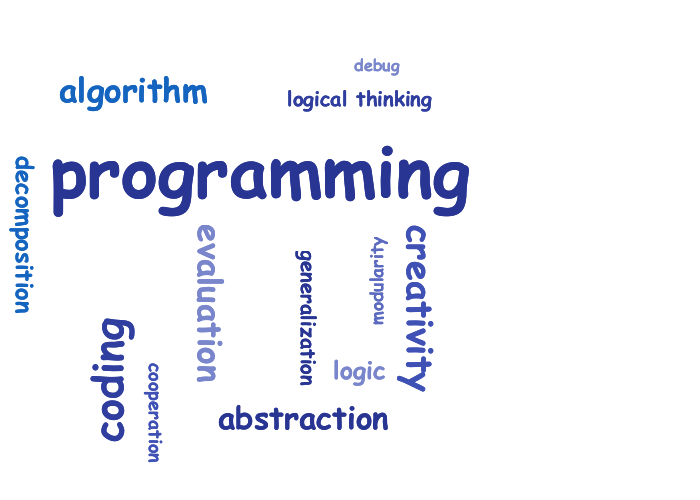

In [38]:
// --- Inicio del Código para la Nube de Palabras de "Habilidades" ---

// Importaciones necesarias (asegúrate de que estén presentes y sean correctas para tu entorno)
import com.kennycason.kumo.WordCloud
import com.kennycason.kumo.WordFrequency
import com.kennycason.kumo.CollisionMode
import com.kennycason.kumo.bg.CircleBackground
import com.kennycason.kumo.font.scale.SqrtFontScalar
import com.kennycason.kumo.palette.ColorPalette
import java.awt.Color
import java.awt.Dimension
import java.io.ByteArrayOutputStream
import java.util.Base64
import org.jetbrains.kotlinx.jupyter.api.HTML // Crucial para mostrar en Jupyter

// Asumimos que 'sortedResults' (List<Pair<String, Int>>) está disponible desde la celda anterior.

// 1. Convertir 'sortedResults' al formato de Kumo
val wordFrequenciesForKumo = sortedResults
    .filter { it.second > 0 }
    .map { WordFrequency(it.first, it.second) }

// 2. La variable 'outputToDisplayInJupyter' obtendrá su valor del resultado del if-else.
val outputToDisplayInJupyter: Any = if (wordFrequenciesForKumo.isNotEmpty()) {
    // Hay datos, procedemos a generar la nube

    // 3. Configuración de Kumo
    val imageDimensions = Dimension(700, 500)
    val kumoWordCloud = WordCloud(imageDimensions, CollisionMode.RECTANGLE)
    kumoWordCloud.setPadding(3)
    kumoWordCloud.setBackground(CircleBackground(240))
    kumoWordCloud.setBackgroundColor(Color(0xFF, 0xFF, 0xFF, 0)) // Fondo transparente
    val kumoColorPalette = ColorPalette(
        Color(0x283593), Color(0x303F9F), Color(0x3F51B5),
        Color(0x5C6BC0), Color(0x7986CB), Color(0x1565C0)
    )
    kumoWordCloud.setColorPalette(kumoColorPalette)
    kumoWordCloud.setFontScalar(SqrtFontScalar(12, 70))

    println("Construyendo nube de palabras para 'Habilidades'...")
    kumoWordCloud.build(wordFrequenciesForKumo)
    println("Nube de palabras para 'Habilidades' construida.")

    val imageOutputStream = ByteArrayOutputStream()

    // 4. El bloque try-catch también es una expresión aquí.
    // Su resultado (un objeto HTML) se convertirá en el resultado del bloque 'if'.
    try {
        kumoWordCloud.writeToStreamAsPNG(imageOutputStream)
        val imageBytes = imageOutputStream.toByteArray()
        val base64EncodedImage = Base64.getEncoder().encodeToString(imageBytes)
        val htmlString = """<img src="data:image/png;base64,$base64EncodedImage" alt="Nube de Palabras para Habilidades"/>"""
        HTML(htmlString) // Esto es lo que devuelve el 'try' si tiene éxito
    } catch (e: Exception) {
        println("ERROR al generar la imagen de la nube de palabras para 'Habilidades': ${e.message}")
        HTML("<b>Error generando la nube de palabras:</b> ${e.message?.replace("<", "&lt;")?.replace(">", "&gt;")}") // Esto devuelve el 'catch'
    }

} else {
    // No hay datos, esto es lo que devuelve el bloque 'else'.
    println("No hay datos con frecuencia positiva para generar la nube de palabras de 'Habilidades'.")
    HTML("<i>No se encontraron datos para la nube de palabras de 'Habilidades'.</i>")
}

// La última expresión de la celda es 'outputToDisplayInJupyter',
// que ahora tiene asignado un objeto HTML de una de las ramas.
outputToDisplayInJupyter
// --- Fin del Código para la Nube de Palabras de "Habilidades" ---

# Funciones para CO-OCURRENCIA

# Frecuencia de aparición de términos en la categoría "Conceptos Computacionales"

In [12]:
val sortedResult = calculateTermFrequencies(terms_conceptos_comp, list_of_abstracts)

plot {
    bars {
        x(sortedResult.map { it.first }.toList(), "Termino") {scale = categorical()}
        y(sortedResult.map { it.second }.toList(), "Frecuencia")
    }
}

<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="0zZp70"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"discrete":true
},{
"aesthetic":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"Termino",
"y":"Frecuencia"
},
"stat":"identity",
"data":{
"Termino":["variables","directions","events","loops","sequences","conditionals","parallelism","control structures","funtions","modular structure","software/hardware"],
"Frecuencia":[62.0,30.0,17.0,16.0,12.0,5.0,2.0,0.0,0.0,0.0,0.0]
},
"sampling":"none",
"position":"dodge",
"geom":"bar"
}]
};
 var plotContainer = document.getElementById("0zZp70");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 variables 
 
 
 
 
 
 
 
 
 directions 
 
 
 
 
 
 
 
 
 events 
 
 
 
 
 
 
 
 
 loops 
 
 
 
 
 
 
 
 
 sequences 
 
 
 
 
 
 
 
 
 conditionals 
 
 
 
 
 
 
 
 
 parallelism 
 
 
 
 
 
 
 
 
 control structures 
 
 
 
 
 
 
 
 
 funtions 
 
 
 
 
 
 
 
 
 modular structure 
 
 
 
 
 
 
 
 
 software/hardware 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 
 
 
 
 20 
 
 
 
 
 
 
 40 
 
 
 
 
 
 
 60 
 
 
 
 
 
 
 
 
 Frecuencia 
 
 
 
 
 Termino

# Frecuencia de aparición de términos en la categoría "Actitudes"

In [13]:
val sortedResult = calculateTermFrequencies(terms_actitudes, list_of_abstracts)
plot {
    bars {
        x(sortedResult.map { it.first }.toList(), "Termino") {scale = categorical()}
        y(sortedResult.map { it.second }.toList(), "Frecuencia")
    }
}

<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="zxtak5"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"discrete":true
},{
"aesthetic":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"Termino",
"y":"Frecuencia"
},
"stat":"identity",
"data":{
"Termino":["self-efficacy","engagement","motivation","perceptions","emotional","persistence","self-perceived"],
"Frecuencia":[83.0,78.0,55.0,38.0,28.0,2.0,0.0]
},
"sampling":"none",
"position":"dodge",
"geom":"bar"
}]
};
 var plotContainer = document.getElementById("zxtak5");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 self-efficacy 
 
 
 
 
 
 
 
 
 engagement 
 
 
 
 
 
 
 
 
 motivation 
 
 
 
 
 
 
 
 
 perceptions 
 
 
 
 
 
 
 
 
 emotional 
 
 
 
 
 
 
 
 
 persistence 
 
 
 
 
 
 
 
 
 self-perceived 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 
 
 
 
 10 
 
 
 
 
 
 
 20 
 
 
 
 
 
 
 30 
 
 
 
 
 
 
 40 
 
 
 
 
 
 
 50 
 
 
 
 
 
 
 60 
 
 
 
 
 
 
 70 
 
 
 
 
 
 
 80 
 
 
 
 
 
 
 
 
 Frecuencia 
 
 
 
 
 Termino

# Frecuencia de aparición de términos en la categoría "Propiedades psicométricas"

In [14]:
val sortedResult = calculateTermFrequencies(terms_prop_psico, list_of_abstracts)

plot {
    bars {
        x(sortedResult.map { it.first }.toList(), "Termino") {scale = categorical()}
        y(sortedResult.map { it.second }.toList(), "Frecuencia")
    }
}

<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="JUW7n8"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"discrete":true
},{
"aesthetic":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"Termino",
"y":"Frecuencia"
},
"stat":"identity",
"data":{
"Termino":["validity","reliability","structural equation model, sem","classical test theory, ctt","item response theory, irt","confirmatory factor analysis, cfa","exploratory factor analysis, efa"],
"Frecuencia":[56.0,37.0,33.0,17.0,17.0,10.0,3.0]
},
"sampling":"none",
"position":"dodge",
"geom":"bar"
}]
};
 var plotContainer = document.getElementById("JUW7n8");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 validity 
 
 
 
 
 
 
 
 
 reliability 
 
 
 
 
 
 
 
 
 structural equation model, sem 
 
 
 
 
 
 
 
 
 classical test theory, ctt 
 
 
 
 
 
 
 
 
 item response theory, irt 
 
 
 
 
 
 
 
 
 confirmatory factor analysis, cfa 
 
 
 
 
 
 
 
 
 exploratory factor analysis, efa 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 
 
 
 
 10 
 
 
 
 
 
 
 20 
 
 
 
 
 
 
 30 
 
 
 
 
 
 
 40 
 
 
 
 
 
 
 50 
 
 
 
 
 
 
 
 
 Frecuencia 
 
 
 
 
 Termino

# Frecuencia de aparición de términos en la categoría "Herramienta de evaluación"

In [15]:
val sortedResult = calculateTermFrequencies(terms_herramienta_eval, list_of_abstracts)
plot {
    bars {
        x(sortedResult.map { it.first }.toList(), "Termino") {scale = categorical()}
        y(sortedResult.map { it.second }.toList(), "Frecuencia")
    }
}

<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="Ju64Q1"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"discrete":true
},{
"aesthetic":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"Termino",
"y":"Frecuencia"
},
"stat":"identity",
"data":{
"Termino":["computational thinking scale, cts","computational thinking test, ctt","ct scale, cts","computational thinking skill levels scale, cts","computational concepts","computational thinking test","the computational thinking scale","beginners computational thinking test, bctt","competent computational thinking test, cctt","computational thinking test for lower primary, cttlp","self-efficacy scale","computational thinking levels scale, ctls","multidimensional 21st century skills scale","stem learning attitude scale","coding attitudes survey, escas","collaborative computing observation instrument","computational thinking skills test, ctst","computational thinking assessment for chinese elementary students, cta-ces","computational thinking challenge, ctc","computational thinking test for elementary school students","computational thinking-skill tasks on numbers and arithmetic","computerized adaptive programming concepts test, capct","elementary student coding attitudes survey, escas","general self-efficacy scale","ict competency test","instrument of computational identity","kbit fluid intelligence subtest","mastery of computational concepts test and an algorithmic test"],
"Frecuencia":[23.0,20.0,15.0,12.0,11.0,10.0,6.0,5.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
},
"sampling":"none",
"position":"dodge",
"geom":"bar"
}]
};
 var plotContainer = document.getElementById("Ju64Q1");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 computational thinking scale, cts 
 
 
 
 
 
 
 
 
 computational thinking test, ctt 
 
 
 
 
 
 
 
 
 ct scale, cts 
 
 
 
 
 
 
 
 
 computational thinking skill levels scale, cts 
 
 
 
 
 
 
 
 
 computational concepts 
 
 
 
 
 
 
 
 
 computational thinking test 
 
 
 
 
 
 
 
 
 the computational thinking scale 
 
 
 
 
 
 
 
 
 beginners computational thinking test, bctt 
 
 
 
 
 
 
 
 
 competent computational thinking test, cctt 
 
 
 
 
 
 
 
 
 computational thinking test for lower primary, cttlp 
 
 
 
 
 
 
 
 
 self-efficacy scale 
 
 
 
 
 
 
 
 
 computational thinking levels scale, ctls 
 
 
 
 
 
 
 
 
 multidimensional 21st century skills scale 
 
 
 
 
 
 
 
 
 stem learning attitude scale 
 
 
 
 
 
 
 
 
 coding attitudes survey, escas 
 
 
 
 
 
 
 
 
 collaborative computing observation instrument 
 
 
 
 
 
 
 
 
 computational thinking skills test, ctst 
 
 
 
 
 
 
 
 
 computational thinking assessment for chinese elementary students, cta-ces 
 
 
 
 
 
 
 
 
 computational thinking challenge, ctc 
 
 
 
 
 
 
 
 
 computational thinking test for elementary school students 
 
 
 
 
 
 
 
 
 computational thinking-skill tasks on numbers and arithmetic 
 
 
 
 
 
 
 
 
 computerized adaptive programming concepts test, capct 
 
 
 
 
 
 
 
 
 elementary student coding attitudes survey, escas 
 
 
 
 
 
 
 
 
 general self-efficacy scale 
 
 
 
 
 
 
 
 
 ict competency test 
 
 
 
 
 
 
 
 
 instrument of computational identity 
 
 
 
 
 
 
 
 
 kbit fluid intelligence subtest 
 
 
 
 
 
 
 
 
 mast

# Frecuencia de aparición de términos en la categoría "Diseño de investigación"

In [16]:
val sortedResult = calculateTermFrequencies(terms_disenio_inves, list_of_abstracts)
plot {
    bars {
        x(sortedResult.map { it.first }.toList(), "Termino") {scale = categorical()}
        y(sortedResult.map { it.second }.toList(), "Frecuencia")
    }
}

<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="EwdJM8"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"discrete":true
},{
"aesthetic":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"Termino",
"y":"Frecuencia"
},
"stat":"identity",
"data":{
"Frecuencia":[140.0,18.0,9.0,8.0,0.0,0.0,0.0],
"Termino":["experimental","post-test","mixed methods","pre-test","no experimental","longitudinal research","quasi-experiments"]
},
"sampling":"none",
"position":"dodge",
"geom":"bar"
}]
};
 var plotContainer = document.getElementById("EwdJM8");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 experimental 
 
 
 
 
 
 
 
 
 post-test 
 
 
 
 
 
 
 
 
 mixed methods 
 
 
 
 
 
 
 
 
 pre-test 
 
 
 
 
 
 
 
 
 no experimental 
 
 
 
 
 
 
 
 
 longitudinal research 
 
 
 
 
 
 
 
 
 quasi-experiments 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 
 
 
 
 50 
 
 
 
 
 
 
 100 
 
 
 
 
 
 
 
 
 Frecuencia 
 
 
 
 
 Termino

# Frecuencia de aparición de términos en la categoría "Nivel de escolaridad"

In [17]:
val sortedResult = calculateTermFrequencies(terms_nivel_escol, list_of_abstracts)
plot {
    bars {
        x(sortedResult.map { it.first }.toList(), "Termino")
        y(sortedResult.map { it.second }.toList(), "Frecuencia")
    }
}


<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="SP9CdL"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"discrete":true
},{
"aesthetic":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"Termino",
"y":"Frecuencia"
},
"stat":"identity",
"data":{
"Termino":["primary school, primary education, elementary school","university, college","high school, higher education","early childhood education, kindergarten, preschool","secondary school, secondary education","upper elementary education, upper elementary school"],
"Frecuencia":[106.0,97.0,92.0,57.0,46.0,0.0]
},
"sampling":"none",
"position":"dodge",
"geom":"bar"
}]
};
 var plotContainer = document.getElementById("SP9CdL");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 primary school, primary education, elementary school 
 
 
 
 
 
 
 
 
 university, college 
 
 
 
 
 
 
 
 
 high school, higher education 
 
 
 
 
 
 
 
 
 early childhood education, kindergarten, preschool 
 
 
 
 
 
 
 
 
 secondary school, secondary education 
 
 
 
 
 
 
 
 
 upper elementary education, upper elementary school 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 
 
 
 
 
 
 Frecuencia 
 
 
 
 
 Termino

# Frecuencia de aparición de términos en la categoría "Medio"

In [18]:
val res = calculateTermFrequencies(terms_medio, list_of_abstracts)
plot {
    bars {
        x(res.map { it.first }.toList(), "Termino")
        y(res.map { it.second }.toList(), "Frecuencia")
    }
}

<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="LqBLbR"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"discrete":true
},{
"aesthetic":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"Termino",
"y":"Frecuencia"
},
"stat":"identity",
"data":{
"Frecuencia":[526.0,175.0,91.0,24.0,24.0,4.0,3.0,2.0,1.0],
"Termino":["programming","stem","robotics","plugged activities","unplugged activities","mobile application","pair programming","block programming","spreadsheet"]
},
"sampling":"none",
"position":"dodge",
"geom":"bar"
}]
};
 var plotContainer = document.getElementById("LqBLbR");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 programming 
 
 
 
 
 
 
 
 
 stem 
 
 
 
 
 
 
 
 
 robotics 
 
 
 
 
 
 
 
 
 plugged activities 
 
 
 
 
 
 
 
 
 unplugged activities 
 
 
 
 
 
 
 
 
 mobile application 
 
 
 
 
 
 
 
 
 pair programming 
 
 
 
 
 
 
 
 
 block programming 
 
 
 
 
 
 
 
 
 spreadsheet 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 
 
 
 
 100 
 
 
 
 
 
 
 200 
 
 
 
 
 
 
 300 
 
 
 
 
 
 
 400 
 
 
 
 
 
 
 500 
 
 
 
 
 
 
 
 
 Frecuencia 
 
 
 
 
 Termino

# Frecuencia de aparición de términos en la categoría "Estrategia"

In [19]:
val res = calculateTermFrequencies(terms_estrate, list_of_abstracts)
plot {
    bars {
        x(res.map { it.first }.toList(), "Termino")
        y(res.map { it.second }.toList(), "Frecuencia")
    }
}


<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="Rt1j8N"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"discrete":true
},{
"aesthetic":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"Termino",
"y":"Frecuencia"
},
"stat":"identity",
"data":{
"Termino":["collaborative learning","project-based learning","game-based learning","gamification","personalized learning","inquiry-based learning","flipped classroom","problem-based learning","design-based learning","technology-enhanced learning","cooperative learning","evidence-centred design approach","universal design for learning","construct-by-self mind mapping","construct-on-scaffold mind mapping","reverse engineering pedagogy"],
"Frecuencia":[30.0,21.0,15.0,10.0,8.0,5.0,4.0,4.0,3.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0]
},
"sampling":"none",
"position":"dodge",
"geom":"bar"
}]
};
 var plotContainer = document.getElementById("Rt1j8N");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 collaborative learning 
 
 
 
 
 
 
 
 
 project-based learning 
 
 
 
 
 
 
 
 
 game-based learning 
 
 
 
 
 
 
 
 
 gamification 
 
 
 
 
 
 
 
 
 personalized learning 
 
 
 
 
 
 
 
 
 inquiry-based learning 
 
 
 
 
 
 
 
 
 flipped classroom 
 
 
 
 
 
 
 
 
 problem-based learning 
 
 
 
 
 
 
 
 
 design-based learning 
 
 
 
 
 
 
 
 
 technology-enhanced learning 
 
 
 
 
 
 
 
 
 cooperative learning 
 
 
 
 
 
 
 
 
 evidence-centred design approach 
 
 
 
 
 
 
 
 
 universal design for learning 
 
 
 
 
 
 
 
 
 construct-by-self mind mapping 
 
 
 
 
 
 
 
 
 construct-on-scaffold mind mapping 
 
 
 
 
 
 
 
 
 reverse engineering pedagogy 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 
 
 
 
 20 
 
 
 
 
 
 
 
 
 Frecuencia 
 
 
 
 
 Termino

# Frecuencia de aparición de términos en la categoría "Herramienta"

In [22]:
val res = calculateTermFrequencies(terms_herramienta, list_of_abstracts)
plot {
    bars {
        x(res.map { it.first }.toList(), "Termino")
        y(res.map { it.second }.toList(), "Frecuencia")
    }
}

<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="JWhVS6"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"discrete":true
},{
"aesthetic":"y",
"limits":[null,null]
}],
"layers":[{
"mapping":{
"x":"Termino",
"y":"Frecuencia"
},
"stat":"identity",
"data":{
"Frecuencia":[68.0,15.0,6.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
"Termino":["scratch","arduino","alice","cubetto","code.org","scratchjr","blockly games","codecombat","csunplugged","robot turtles","hello ruby","kodable","lightbotjr","kibo robots","bee bot","minecraft","agent sheets","mimo","py– learn","spacechem"]
},
"sampling":"none",
"position":"dodge",
"geom":"bar"
}]
};
 var plotContainer = document.getElementById("JWhVS6");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 scratch 
 
 
 
 
 
 
 
 
 arduino 
 
 
 
 
 
 
 
 
 alice 
 
 
 
 
 
 
 
 
 cubetto 
 
 
 
 
 
 
 
 
 code.org 
 
 
 
 
 
 
 
 
 scratchjr 
 
 
 
 
 
 
 
 
 blockly games 
 
 
 
 
 
 
 
 
 codecombat 
 
 
 
 
 
 
 
 
 csunplugged 
 
 
 
 
 
 
 
 
 robot turtles 
 
 
 
 
 
 
 
 
 hello ruby 
 
 
 
 
 
 
 
 
 kodable 
 
 
 
 
 
 
 
 
 lightbotjr 
 
 
 
 
 
 
 
 
 kibo robots 
 
 
 
 
 
 
 
 
 bee bot 
 
 
 
 
 
 
 
 
 minecraft 
 
 
 
 
 
 
 
 
 agent sheets 
 
 
 
 
 
 
 
 
 mimo 
 
 
 
 
 
 
 
 
 py– learn 
 
 
 
 
 
 
 
 
 spacechem 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 
 
 
 
 20 
 
 
 
 
 
 
 40 
 
 
 
 
 
 
 60 
 
 
 
 
 
 
 
 
 Frecuencia 
 
 
 
 
 Termino

# Construccion de nube de palabras